### sigma校准与结果修正的展示

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d
from function import HW1FSwaption,SimulatedAnnealingSwaption,Matrixisation
from collections import namedtuple
from function import create_swaption_helpers,calibration_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import QuantLib as ql
import math
import statsmodels.api as sm

from pandas import DataFrame

#### 数据导入与预处理

In [2]:
ZeroRate = np.array(pd.read_excel('ZeroRate.xlsx', sheet_name='Sheet1').iloc[0:62,0:601], dtype=float) * 0.01
#ZeroRate.shape=(63, 241)

swaptionrate = np.array(pd.read_excel('swaption2023.xlsx', sheet_name='Sheet1').iloc[1:64,77:85], dtype=float) * 0.01
#插值补全缺失值
x = np.linspace(0, 61, 62)
for i in range(8):
    y = swaptionrate[:, i]
    x_clean = x[~np.isnan(y)]
    y_clean = y[~np.isnan(y)]
    f = interp1d(x_clean, y_clean, kind='linear')
    swaptionrate[:, i] = f(x)
#swaptionrate.shape=(62, 8)
swaptionrateglobal = np.full((62,72),1.0)
col_index = 0
for s in range(72):
    swaptionrateglobal[:, s] = swaptionrate[:, col_index]
    if (s + 1) % 9 == 0:
        col_index += 1       
SwaptionRate=swaptionrateglobal

a_calibrated = np.array(pd.read_excel('a_calibrated.xlsx', sheet_name='Sheet1').iloc[0:62,0], dtype=float)  
#a_calibrated.shape=(62,1)

tenor = np.array([1.0]*9 + [2.0]*9 + [3.0]*9 + [4.0]*9 + [5.0]*9 + [10.0]*9 + [15.0]*9 + [20.0]*9)
maturity = np.array([1,2,3,4,5,6,7,8,10]*8)
#weight=np.array([1.0]*2 +[5.0]*7+ [10.0]*9 + [15.0]*9 + [20.0]*9 + [20.0]*9 + [25.0]*9 + [22.0]*9 + [20.0]*9)
weight=np.reciprocal((tenor*maturity))

Market_Price=np.array(pd.read_excel('MarketPrice.xlsx', sheet_name='Sheet1').iloc[0:62,0:72], dtype=float)
#listmin_sigma=np.array(pd.read_excel('listmin_sigma_as_initial.xlsx', sheet_name='Sheet1'), dtype=float)  
#listmin_cost=np.array(pd.read_excel('listmin_cost_as_initial.xlsx', sheet_name='Sheet1'), dtype=float)  


以4月28日为例（均值回归a单独校准后作为已知量）

In [3]:
calibrate_sigma_0428=SimulatedAnnealingSwaption(a_calibrated[0],0.00936242,maturity,tenor,ZeroRate[0],SwaptionRate[0],4,Market_Price[0],weight,0,0.0001,50,0.09)
calibrate_sigma_0428.Mesh()
calibrate_sigma_0428.Optimiser()

全局校准得到波动率sigma

In [4]:
calibrate_sigma_0428.sigma_calibrated

array([0.00962263])

In [5]:
calibrate_sigma_0428.cost_value

8.29811532245777e-05

#### Quantlib定价

In [6]:
today=ql.Date(28,4,2023)
curve_start_date = today
curve_date = [curve_start_date]
current_date = curve_start_date
while len(curve_date) < 601:
    current_date = ql.Date(current_date.dayOfMonth(), current_date.month(), current_date.year())
    current_date += ql.Period(1, ql.Months)
    curve_date.append(current_date)

ql.Settings.instance().evaluationDate = today   #evaluationDate
term_structure = ql.YieldTermStructureHandle(ql.ZeroCurve(curve_date, ZeroRate[0,:], ql.Actual360()))
index = ql.USDLibor(ql.Period('6M'),term_structure)

CalibrationData = namedtuple("CalibrationData","start, length, volatility")
data=[]
for instru_type in range(0,72):
    calibration_data = CalibrationData(maturity[instru_type], tenor[instru_type], calibrate_sigma_0428.sigma_calibrated[0] )
    data.append(calibration_data)
    
model = ql.HullWhite(term_structure)
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)
optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)
result_save=calibration_report(swaptions, data)
    

Cumulative Error Price: 0.33671
Cumulative Error Vols : 0.33667


In [7]:
price_sigma_0428=result_save['Market Price'].values

处理数据便于后续分析

In [8]:
matrix_Swaption_Price_0428=Matrixisation(price_sigma_0428)
matrix_Swaption_Price_0428.Output()
matrix_Swaption_Price_0428=matrix_Swaption_Price_0428.matrix

matrix_Market_Price_0428=Matrixisation(Market_Price[0,:])
matrix_Market_Price_0428.Output()
matrix_Market_Price_0428=matrix_Market_Price_0428.matrix

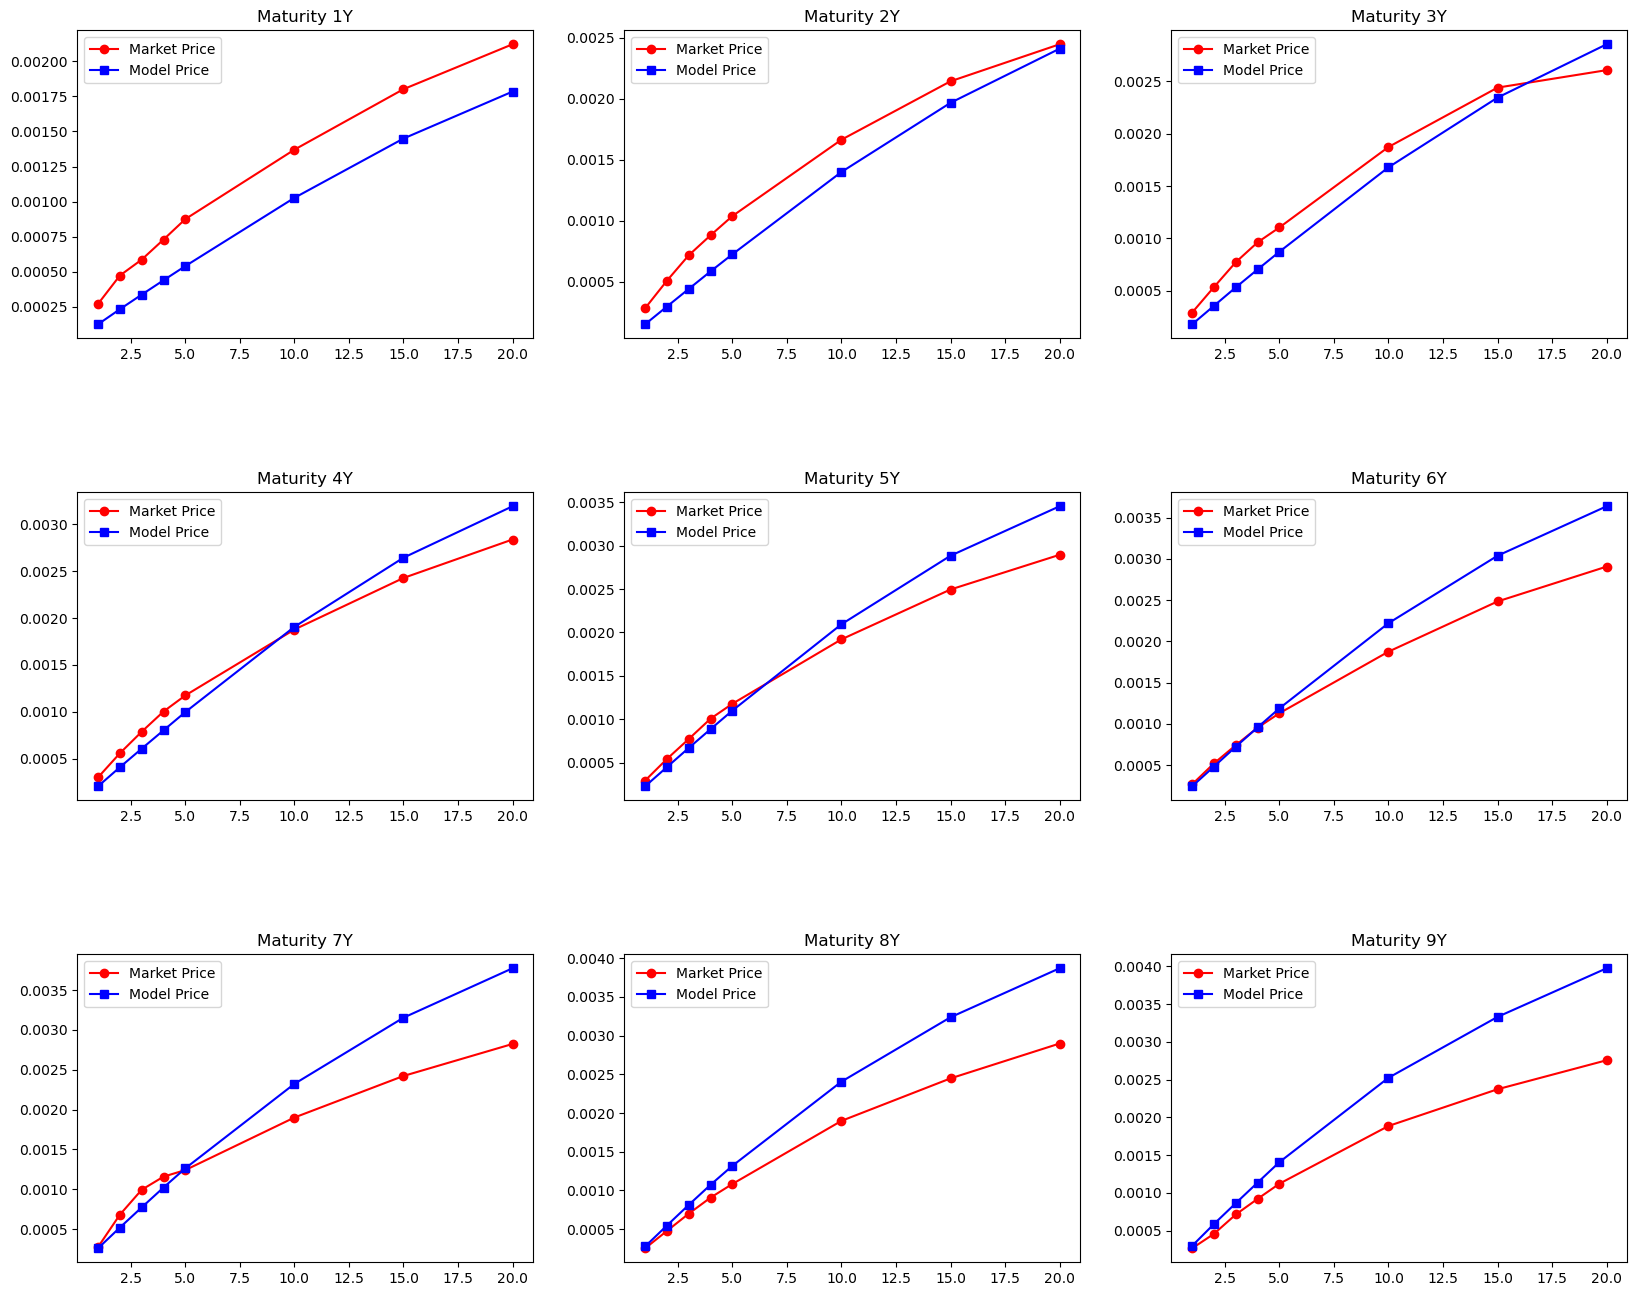

In [9]:
# 设置图表大小和布局
fig, axs = plt.subplots(3, 3, figsize=(20, 16))
fig.subplots_adjust(hspace=0.5)  # 调整子图间距

# 循环绘制图表
for i, ax in enumerate(axs.flat):
    if i < 9:  
        # 生成示例数据
        x = [1, 2, 3, 4, 5, 10, 15, 20]
        y = matrix_Market_Price_0428[i,:]
        z = matrix_Swaption_Price_0428[i,:]

        # 绘制图表
        ax.plot(x, y, color='red',marker='o', linestyle='-',label='Market Price')
        ax.plot(x, z, color='blue',marker='s', linestyle='-',label='Model Price')
        ax.legend(loc='upper left')
        ax.set_title(f'Maturity {i+1}Y')  # 添加标题

plt.show()

下面进行数据修正。修正方法是使用线性回归拟合模型价格与市场价格的误差

In [111]:
X=np.vstack((maturity, tenor)).T
Y=Market_Price[0]-price_sigma_0428
Y=Y.reshape(-1, 1)
X=sm.add_constant(X)
model=sm.OLS(Y,X).fit()
predictions=model.predict(X)
print_model=model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     135.7
Date:                Fri, 15 Sep 2023   Prob (F-statistic):           1.22e-24
Time:                        01:52:13   Log-Likelihood:                 525.50
No. Observations:                  72   AIC:                            -1045.
Df Residuals:                      69   BIC:                            -1038.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   4.74e-05     13.244      0.0

系数显著，拟合得到误差项：
$$Err=0.0006-8.639*{10}^{-5}*Maturity-3.421*{10}^{-5}*Tenor $$

In [113]:
price_sigma_0428_corrected=price_sigma_0428+predictions

matrix_Swaption_Price_corrected_0428=Matrixisation(price_sigma_0428_corrected)
matrix_Swaption_Price_corrected_0428.Output()
matrix_Swaption_Price_corrected_0428=matrix_Swaption_Price_corrected_0428.matrix

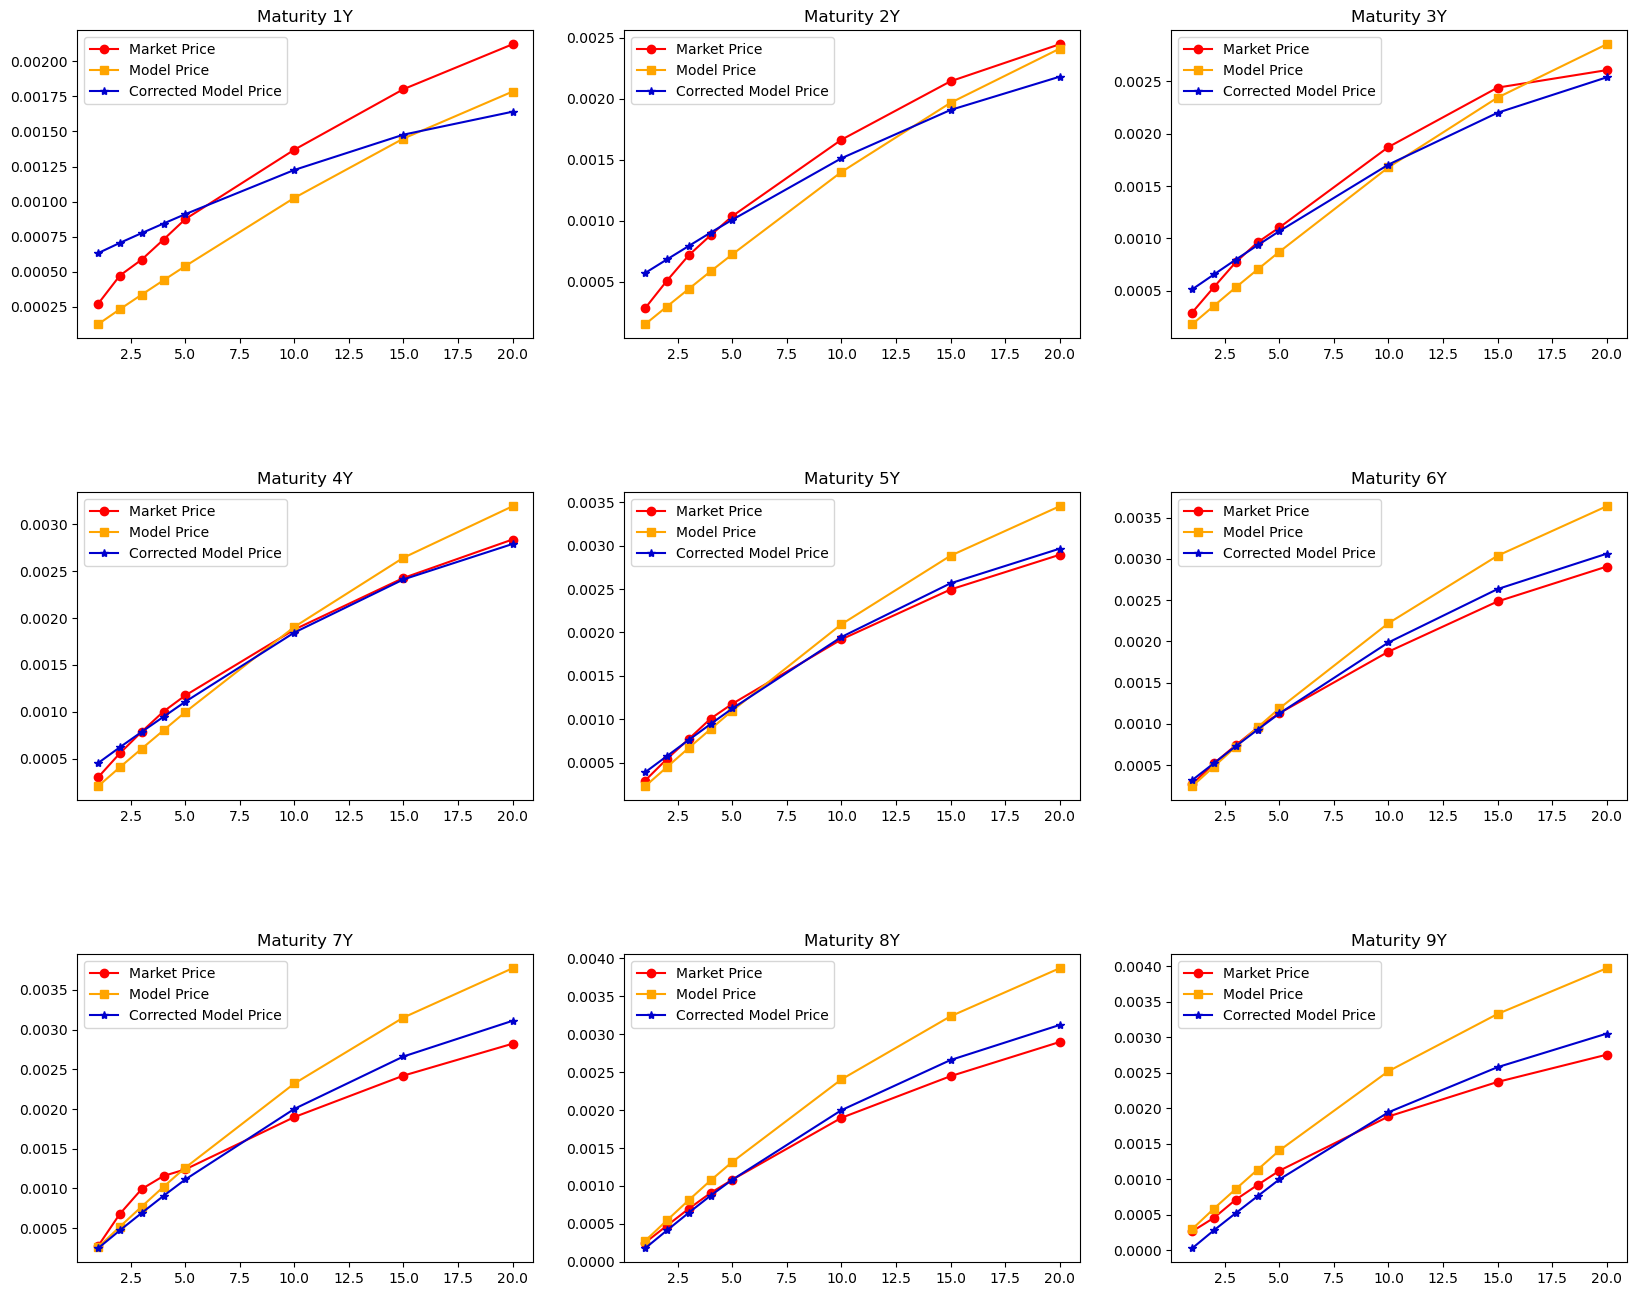

In [114]:
# 设置图表大小和布局
fig, axs = plt.subplots(3, 3, figsize=(20, 16))
fig.subplots_adjust(hspace=0.5)  # 调整子图间距

# 循环绘制图表
for i, ax in enumerate(axs.flat):
    if i < 9:  
        
        x = [int(1), int(2), int(3), int(4), int(5), int(10), int(15), int(20)]
        y = matrix_Market_Price_0428[i,:]
        z = matrix_Swaption_Price_0428[i,:]
        w = matrix_Swaption_Price_corrected_0428[i,:]

        # 绘制图表
        
        ax.plot(x, y, color='red',marker='o', linestyle='-',label='Market Price')
        ax.plot(x, z, color='orange',marker='s', label='Model Price')
        ax.plot(x, w, color='mediumblue',marker='*', linestyle='-',label='Corrected Model Price')
        ax.legend(loc='upper left')
        ax.set_title(f'Maturity {i+1}Y')  # 添加标题

plt.show()

#### co-tenor校准
本项目使用的校准工具一共有八种Tenor: 1Y 2Y 3Y 4Y 5Y 10Y 15Y 20Y

In [95]:
matrix_Market_Price_0428=Matrixisation(Market_Price[0,:])
matrix_Market_Price_0428.Output()
matrix_Market_Price_0428=matrix_Market_Price_0428.matrix

cotenor_sigmalist_0428=np.array([])
tenor_list=np.array([1,2,3,4,5,10,15,20])
SwaptionRate_list=SwaptionRate[0,::9]

In [96]:
for num_tenor in range(8):
    obj=SimulatedAnnealingSwaption(a_calibrated[0],0.00936242,maturity[:9],np.array([tenor_list[num_tenor]]*9),ZeroRate[0],np.array([SwaptionRate_list[num_tenor]]*9),4,matrix_Market_Price_0428[:,num_tenor],(1/maturity[:9])/np.array([3,4,5,7,8,8,8,7])[num_tenor],0,0.0001,50,0.09)
    obj.Mesh()
    obj.Optimiser()
    cotenor_sigmalist_0428=np.append(cotenor_sigmalist_0428,obj.sigma_calibrated)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


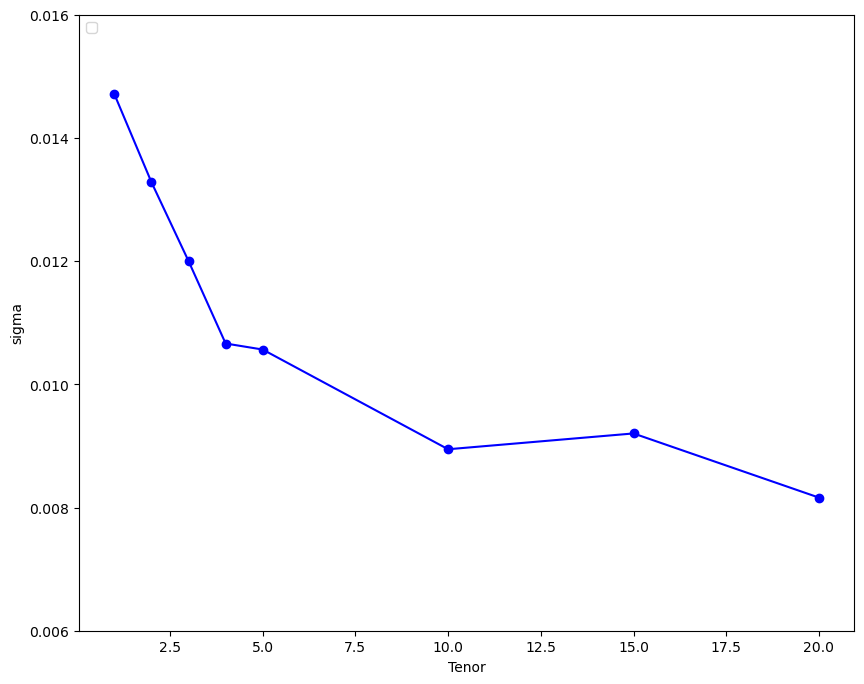

In [97]:
fig, ax = plt.subplots(figsize=(10, 8))

x = [int(1), int(2), int(3), int(4), int(5), int(10), int(15), int(20)]
y = cotenor_sigmalist_0428
ax.plot(x, y, color='blue', marker='o', linestyle='-')


ax.legend(loc='upper left')
ax.set_xlabel('Tenor')
ax.set_ylabel('sigma')
ax.set_ylim(0.006,0.016) 

plt.show()